In [95]:
# This notebook implements the examples from Lagaris 
using Lux, NeuralPDE, Zygote
using ModelingToolkit
using ModelingToolkit: Interval
using OrdinaryDiffEq
using LineSearches
using ProgressMeter
using Gnuplot
gpexec("load '~/gpconfig.cfg'")
import Base.show # this is needed otherwise the next line just defines a new function in a new module
show(io::IO, ::MIME"text/html", gp::Gnuplot.GPSession) = Gnuplot._show(io, gp, "svg enhanced standalone mouse size 400,250")
Gnuplot.options.verbose = false;
dump(Gnuplot.options) # print out the options

# https://julialang.slack.com/archives/C690QRAA3/p1711534935292689
# What is the relationship between Optimization.jl and Optimisers.jl?
# Optimization.jl is an interface over a whole set of optimization packages. It's the level of DifferentialEquations.jl, NonlinearSolve.jl, LinearSolve.jl, interfacing to tons (>10?) optimization packages.
# Optimisers.jl is a specific library of optimizers. Optimisers.jl is a specific library of optimizers.
# Optimization.jl has a wrapper for using Optimisers.jl methods (OptimizationOptimisers.jl), and that's the most common way things are trained with SciML applications like Neural ODEs.
# Optim.jl (OptimizationOptimJL.jl) is another Julia package implementing various algorithms to perform univariate and multivariate optimization
using Optimization, OptimizationOptimJL, OptimizationOptimisers
using Random, Statistics

Gnuplot.Options
  dry: Bool false
  cmd: String "gnuplot"
  default: Symbol default
  term: String "qt 0 font \"Sans,9\""
  gpviewer: Bool false
  init: Array{String}((0,))
  verbose: Bool false
  preferred_format: Symbol auto


Problem 1: A first order ODE 
$$
\frac{d} {d x} \Psi+( x+\frac{1+3 x^{2}} {1+x+x^{3}} ) \Psi=x^{3}+2 x+x^{2} \frac{1+3 x^{2}} {1+x+x^{3}} 
$$
with initial conditions $\Psi(0) = 1$, dependent variable $x$ with domain $x \in [0, 1]$.


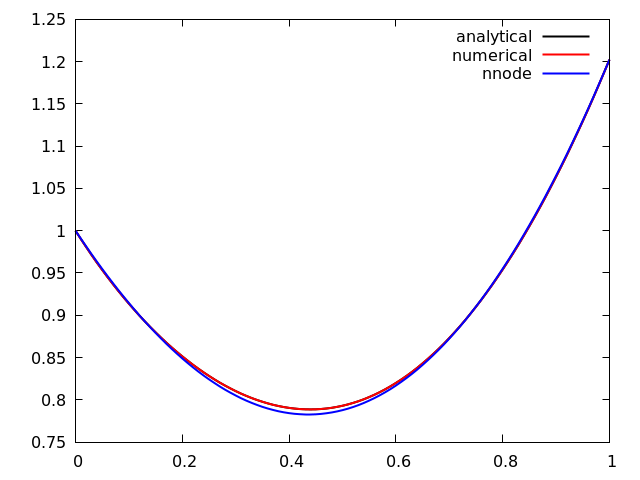

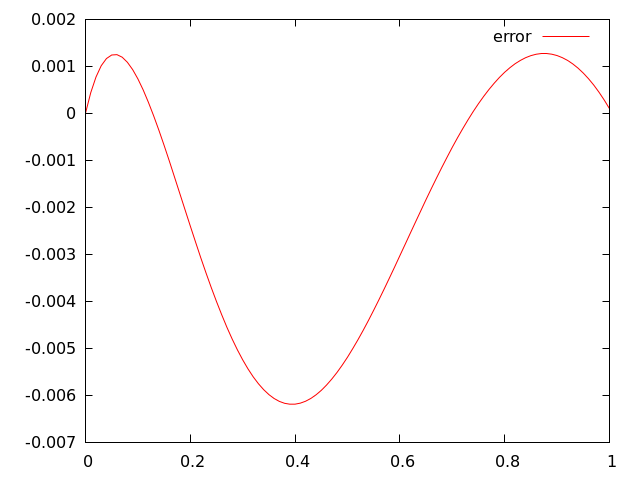

In [35]:
# Let's solve the following simple, linear ODE to get a sense of how to use the package 
analytical(t) = exp((-t^2)/(2))/(1 + t + t^3) + t^2
linear(u, p, t) = -(t + (1 + 3*t^2)/(1 + t + t^3))*u + t^3 + 2*t + t^2*((1 + 3*t^2)/(1 + t + t^3))
tspan = (0.0, 1.0)
u0 = 1
prob = ODEProblem(linear, u0, tspan) # we can of course solve this with traditional diffeq solvers
sol = solve(prob, Tsit5(), saveat = 0.01)
ground_truth = analytical.(sol.t)

# Let's the NNODE API to also solve this 
rng = Random.default_rng()
Random.seed!(rng, 0)
chain = Chain(Dense(1, 6, σ), Dense(6, 1)) # create a 2 layer, 5 neuron NN
ps, st = Lux.setup(rng, chain) |> Lux.f64 
opt = OptimizationOptimisers.Adam(0.1) # set up the optimiser 
alg = NNODE(chain, opt, init_params = ps, strategy=GridTraining(0.1))
nn = solve(prob, alg, verbose = false, maxiters = 500, saveat = 0.01)

@gp "reset" 
@gp :- sol.t ground_truth "with lines title 'analytical' lc 'black' lw 2"
@gp :- sol.t sol.u "with lines title 'numerical' lc 'red' lw 2"
@gp :- nn.t nn.u "with lines title 'nnode' lc 'blue' lw 2"
display(@gp)

@gp "reset"
@gp :- sol.t (nn.u .- ground_truth) "with lines title 'error' lc 'red'"

# System of Equations and Parameter Estimation. 
---- 

Can we estimate parameters of a system? Consider the Lorenz system: 
$$
\begin{aligned} 
    x' &= \sigma (y - x) \\
    y' &= x (\rho - z) - y \\
    z' &= xy - \beta z
\end{aligned}
$$
with parameter values $\sigma = 10.0, \rho = 28.0, \beta = \frac{8}{3}$

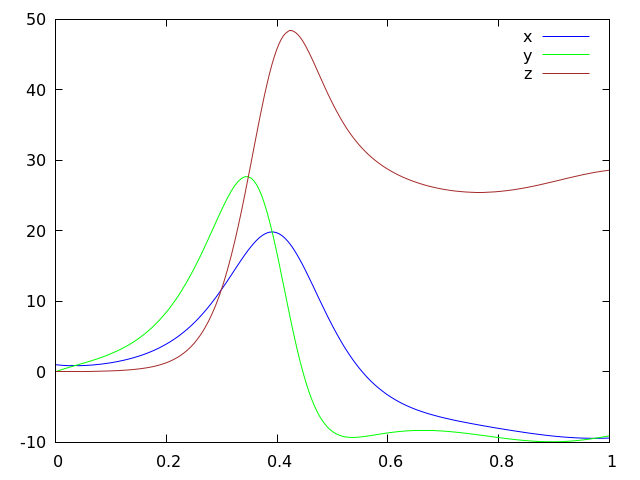

In [58]:
# Use MTK to set up the model 
@parameters t, σ_, β, ρ 
@variables x(..), y(..), z(..)
Dt = Differential(t) # set up the differential operator 
eqs = [Dt(x(t)) ~ σ_ * (y(t) - x(t)),
       Dt(y(t)) ~ x(t) * (ρ - z(t)) - y(t),
       Dt(z(t)) ~ x(t) * y(t) - β * z(t)]

bcs = [x(0) ~ 1.0, y(0) ~ 0.0, z(0) ~ 0.0]
domains = [t ∈ Interval(0.0, 1.0)] # this is an array because it would contain the domains of all dependent parameters for mutlivariate functions
dt = 0.01

# Let's solve this system using regular numerical solver 
# Remember the goal here is to estimate parameters
@mtkbuild c = ODESystem(eqs, t)
u0 = [c.x => 1.0, c.y => 0.0, c.z => 0.0]
prob = ODEProblem(c, u0, (0.0, 1.0), [10.0, 28.0, 8 / 3])
sol_numerical = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8) # uses the numerical solver algorithm 
@gp "reset" 
@gp :- sol_numerical.t sol_numerical[1, :] "with lines title 'x' lc 'blue'"
@gp :- sol_numerical.t sol_numerical[2, :] "with lines title 'y' lc 'green'"
@gp :- sol_numerical.t sol_numerical[3, :] "with lines title 'z' lc 'brown'"


In [107]:
# let's solve with PINN API to do the forward simulation 
# We can't use the NNODE API because of the way we've deinfed the ODE (i.e. using MTK)
# i.e., running
# alg = NNODE(chain, opt, init_params = ps, strategy=GridTraining(0.1))
# nn = solve(prob, alg, verbose = false, maxiters = 500, saveat = 0.01)
# returns error: The NNODE solver only supports out-of-place ODE definitions, i.e. du=f(u,p,t).    

rng = Random.default_rng()
Random.seed!(rng, 0)
input_ = length(domains)
n = 8
chain1 = Lux.Chain(Dense(input_, n, Lux.σ), Dense(n, n, Lux.σ), Dense(n, n, Lux.σ), Dense(n, 1))
chain2 = Lux.Chain(Dense(input_, n, Lux.σ), Dense(n, n, Lux.σ), Dense(n, n, Lux.σ), Dense(n, 1))
chain3 = Lux.Chain(Dense(input_, n, Lux.σ), Dense(n, n, Lux.σ), Dense(n, n, Lux.σ), Dense(n, 1))

strategy = NeuralPDE.QuadratureTraining(; abstol = 1e-6, reltol = 1e-6, batch = 200)
#strategy = NeuralPDE.GridTraining(dt)
discretization = NeuralPDE.PhysicsInformedNN([chain1, chain2, chain3], strategy, param_estim=false)
@named pdesystem = PDESystem(eqs, bcs, domains, [t], [x(t), y(t), z(t)],  [σ_, ρ, β], defaults = Dict([σ_ .=> 10.0, ρ => 28.0, β => 8/3]))
prob = discretize(pdesystem, discretization)
opt = BFGS(linesearch = BackTracking())
res = Optimization.solve(prob, opt; maxiters = 1000)
#.BFGS
#BFGS(linesearch = LineSearches.BackTracking())

retcode: Failure
u: ComponentVector{Float64}(depvar = (x = (layer_1 = (weight = [0.406926946808541; -1.4137643448033284; … ; -5.736333220112253; -5.626335206085578;;], bias = [-1.3697859747066186; -1.0873525953407075; … ; -5.752886834078049; -6.410528037930264;;]), layer_2 = (weight = [0.2606592997963734 0.42364407794891024 … 0.32526158691635954 -0.1707612046264595; 1.3579002899953652 -0.21222538165825516 … 0.6707514416619413 -0.519134573056928; … ; 2.3321989434088555 3.7149192826392863 … 3.175906424933836 -1.0141897579824304; 0.2850170263478463 -1.0854283133515392 … -1.3470802500814263 -0.4621152567120367], bias = [1.111384781413341; -1.0714282240571755; … ; 4.517018130791641; -0.8217136780432055;;]), layer_3 = (weight = [3.244219291084883 -1.8907705624840803 … -0.05979675910096362 -0.8673478428593262; 7.960575146656998 -2.284202367238887 … -3.02568750980874 -0.3785733350198168; … ; -1.6949402293690463 -0.7514117158336667 … -1.5912473209986482 -0.8277949632157274; -6.828395205907398 2

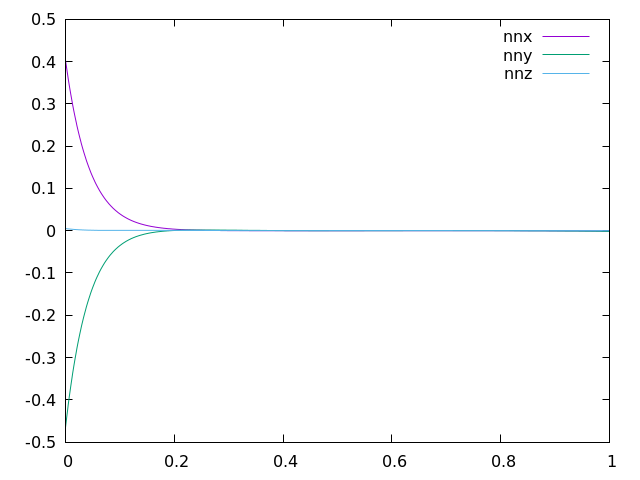

In [105]:

depvars = [:x, :y, :z]
minimizers = [res.u.depvar[depvars[i]] for i in 1:3]
ts = [infimum(d.domain):(0.001):supremum(d.domain) for d in domains][1]
u_predict = [[discretization.phi[i]([t], minimizers[i])[1] for t in ts] for i in 1:3]
@gp "reset" 
@gp :- ts u_predict[1] "with lines title 'nnx'"
@gp :- ts u_predict[2] "with lines title 'nny'"
@gp :- ts u_predict[3] "with lines title 'nnz'"
#ts = [infimum(d.domain):(0.001):supremum(d.domain) for d in domains][1]